In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

from balancers import PredictionBalancer
import tools

First, let's load our data. Here we're using some COVID outbreak investigation data with information about symptoms, test results, and demographics for each person.

In [2]:
records = pd.read_csv('records.csv')

Race will be our protected category. To keep things simple, we'll limit the category to 4 groups: `Black`, `White`, `Asian`, and `Undisclosed`.

In [3]:
records = records[(records.race == 'Black / African American') |
                  (records.race == 'White') |
                  (records.race == 'Asian') |
                  (records.race == 'Undisclosed')]
race = records.race.values

Next, we'll set the true outcome variable, `Y`. This is the thing we're trying to predict fairly across groups. Since PCR is the gold standard for SARS-CoV2 infection, that's what we'll use here.

In [4]:
pcr = records.pcr.values

We also need to come up with some (potentially unfair) predictors to predict test status. We'll start with a few binary symptom variables.

In [5]:
cough = records.cough.values
fever = records.fever.values
taste = records.losstastesmell.values

symptoms = [cough, fever, taste]
symptom_names = ['cough', 'fever', 'taste']

Before stratifying by race, let's start by seeing how well these predict test status overall. `tools.clf_metrics()` produces lots of nice info, so let's use that.

In [6]:
f1_scores = {symptom_names[i]:f1_score(pcr, s) for i, s in enumerate(symptoms)}

In [7]:
f1_scores

{'cough': 0.32067510548523204,
 'fever': 0.33962264150943394,
 'taste': 0.38972162740899363}

All 3 symptoms predict pretty well. Loss of taste and/or smell is strong on both Youden's J and F1-score, though, so let's say it's the best overall. Now we can use an instance of the `PredictionBalancer` to whether it performs fairly across groups.

In [8]:
pb = PredictionBalancer(y=pcr, y_=fever, a=race)


Pre-adjustment group rates are 

                   group     fpr     tpr
                   Asian   0.027     0.1
Black / African American    0.04   0.125
             Undisclosed  0.0676  0.2838
                   White   0.044  0.3284

And loss is 0.1052



We can see that there's some definite imbalance between the groups, with fever's sensitivity (`tpr`) for both blacks and Asians being less than a third of what it is for whites. Let's use the `.adjust()` method to see if we can balance those out.

In [9]:
pb.adjust()


Post-adjustment group rates are 

                   group     fpr     tpr
                   Asian   0.027     0.1
Black / African American  0.0267   0.125
             Undisclosed  0.0405  0.0541
                   White  0.0313  0.1324

And loss is 0.1088



{'loss': 0.15803140554710288, 'roc': (0.0341, 0.1066)}

`pb.adjust()` returns the theoretical optima for loss (1 - accuracy, in this case) and the ROC coordinates after adjustment. With equalized odds, the best we can do for all groups is a FPR of 3% (very specific!) and TPR of 10% (not very sensitive).

By default, the adjuster also prints the ROC coordinates for the model's empirical predictions on the original dataset. Because of the sampling used to generate the predictions, these will often vary from the theoretical optima, but their long-run averages will be correct.

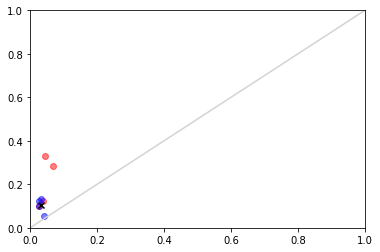

In [10]:
pb.plot()